# U.S. Federal Public Debt Holders
This notebook examines how the ownership of **U.S. debt held by the public** has evolved over time. It uses quarterly data series from the [Federal Reserve Economic Data (FRED) database](https://fred.stlouisfed.org), including major holder categories such as the Federal Reserve, foreign & international investors, and domestic private investors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

In [3]:
# Human readable column names for DataFrames
FEDERAL_DEBT_TOTAL = 'Total Federal Debt'
FEDERAL_DEBT_HELD_BY_PUBLIC = 'Federal Debt Held by the Public'
FEDERAL_DEBT_HELD_BY_US_GOVERNMENT = 'Debt Held by US Government'
PFX = 'Debt Held by '
FEDERAL_DEBT_HELD_BY_FED = PFX + 'FED'
FEDERAL_DEBT_HELD_BY_FOREIGN = PFX + 'Foreign and International Investors'
FEDERAL_DEBT_HELD_BY_FOREIGN_OFFICIAL = PFX + 'Foreign Official Institutions'
FEDERAL_DEBT_HELD_BY_FOREIGN_OTHER_FOREIGN = PFX + 'Other Foreign and International Investors'
FEDERAL_DEBT_HELD_BY_DOMESTIC = PFX + 'Domestic Owners'

### Federal Debt Holders, preparation of data
There are five relevant dataseries provided by [FRED](https://fred.stlouisfed.org) that could potentially be used:
* `GFDEBTN` &mdash; Federal Debt: Total Public Debt in millions (quarterly frequency). This series accounts for both federal debt held by the public as well as US intragovernmental debt.
* `FYGFDPUN` &mdash; unlike `GFDEBTN` this series accounts only for federal debt held by the public in millions (quarterly frequency).
* `FDHBATN` &mdash; The US intragovernmental part of the debt in millions (quarterly frequency).
* `FDHBFRBN` &mdash; Federal Debt Held by Federal Reserve Banks in billions (quarterly frequency).
* `FDHBFIN` &mdash; Federal Debt Held by Foreign and International Investors in billions (quarterly frequency)

The following relationships hold:
* `GFDEBTN` = `FYGFDPUN` + `FDHBATN`
* US Domestic ownership = `FYGFDPUN` - `FDHBFRBN` - `FDHBFIN`

In [4]:
# GFDEBTN   -- Federal Debt: Total Public Debt in millions (quarterly frequency)
# FYGFDPUN  -- Federal Debt Held by the Public in millions (quarterly frequency)
# FDHBATN   -- Federal Debt Held by Agencies and Trusts in millions (quarterly frequency)
# GFDEBTN = FYGFDPUN + FDHBATN

# FDHBFRBN  -- Federal Debt Held by Federal Reserve Banks in billions (quarterly frequency)
# FDHBFIN   -- Federal Debt Held by Foreign and International Investors in billions (quarterly frequency)
# FYGFDPUN = FDHBFRBN + FDHBFIN + Domestic holdings

pub_debt_holders = web.get_data_fred(['GFDEBTN', 'FYGFDPUN', 'FDHBATN', 'FDHBFRBN', 'FDHBFIN'],
                                     start=report_start, end=report_end)

# Convert all amounts into millions
pub_debt_holders[['FDHBFRBN', 'FDHBFIN']] *= 1000

### Additional data on foreign and international holders
In this section of the notebook I zoom in into Foreign and International holders based on the data provided by [the Treasury International Capital (TIC) System](https://home.treasury.gov/data/treasury-international-capital-tic-system). Unfortunately [the monthly series provided by the TIC](https://ticdata.treasury.gov/resource-center/data-chart-center/tic/Documents/slt_table5.txt) cover only the most recent 13 months. To accumulate past data, I store results retrieved on the filesystem and add to them in the subsequent runs of this notebook.

The TIC data allows to further break down foreign and international investors holdings into those held by:
* **Foreign Official**&mdash;represents the portion of U.S. Treasury securities held by foreign official institutions, such as central banks (e.g., the Bank of Japan), government investment funds (e.g., sovereign wealth funds), and international organizations (e.g., the International Monetary Fund).
* **Other Foregin and International Investors**:
  * Foreign commercial banks
  * Mutual funds and investment funds
  * Pension funds
  * Corporations
  * Individual investors
  * Other private financial institutions (e.g., hedge funds, insurance companies)

It also allows to break it down based on the country of ownership. Moreover, TIC data is more recent than FRED's `FDHBFIN` dataseries, which fequently lags behind by a quarter. I take advantage of it to extend `FDHBFIN` with the most recent quarter data on foreign and international ownership.

#### Foreign Ownership Breakdown: Official Institutions vs. Other Investors

In [5]:
f = pd.read_csv('./treasury_data/tic_table5.csv', index_col=0)
f = f.set_axis(pd.DatetimeIndex(f.index, freq='MS'))

tic_tbl5 = pd.read_table('https://ticdata.treasury.gov/resource-center/data-chart-center/tic/Documents/slt_table5.txt',
                         skiprows=5, skipfooter=11, index_col='Country', engine='python')
tic_tbl5.columns = pd.DatetimeIndex(tic_tbl5.columns, freq='-1MS')
tic_tbl5 = tic_tbl5.T.iloc[::-1] * 1e3

new_months = tic_tbl5.index.difference(f.index)
if not new_months.empty:
    # Deal with individual countries
    interm = pd.concat([f.iloc[:,:-5], tic_tbl5.loc[new_months].iloc[:,:-5]], axis=0)
    interm.update(tic_tbl5.iloc[:,:-5])

    # Deal with 'All Other' and totals
    interm2 = pd.concat([f.iloc[:,-5:], tic_tbl5.loc[new_months].iloc[:,-5:]], axis=0)
    tic_tbl5 = pd.concat([interm, interm2], axis=1)

    # Correct 'All Other' values
    tic_tbl5.iloc[:,-5] += tic_tbl5.iloc[:,-4] - tic_tbl5.iloc[:,:-4].sum(axis=1)
    
    tic_tbl5.to_csv('./treasury_data/tic_table5.csv')
else:
    tic_tbl5 = f

In [6]:
tic_tbl5_qf = tic_tbl5 if pd.offsets.MonthEnd(0).rollforward(tic_tbl5.index[-1]).is_quarter_end\
    else tic_tbl5.iloc[:-(tic_tbl5.index[-1].month % 3)]
tic_tbl5_qf = tic_tbl5_qf.resample('QS').last()

In [7]:
# Updated data on foreign and international ownership with the most recent TIC data
pub_debt_holders.FDHBFIN.update(tic_tbl5_qf.loc[:, 'Grand Total'])

# Extending with a breakdown of foreign & international ownership into that by foreign official institutions and other
pub_debt_holders = pd.concat([pub_debt_holders,
                              tic_tbl5_qf.loc[:, 'Of Which: Foreign Official'].rename(FEDERAL_DEBT_HELD_BY_FOREIGN_OFFICIAL)], axis=1)
pub_debt_holders[FEDERAL_DEBT_HELD_BY_FOREIGN_OTHER_FOREIGN] =\
    pub_debt_holders.FDHBFIN - pub_debt_holders.loc[:, FEDERAL_DEBT_HELD_BY_FOREIGN_OFFICIAL]

# Adding a new column for the domestic part
pub_debt_holders[FEDERAL_DEBT_HELD_BY_DOMESTIC] = pub_debt_holders.FYGFDPUN\
        - pub_debt_holders.FDHBFRBN - pub_debt_holders.FDHBFIN

# Truncating to the earliest quarter where all dataseries have data
pub_debt_holders.dropna(inplace=True, subset=['GFDEBTN', 'FYGFDPUN', 'FDHBATN', 'FDHBFRBN', 'FDHBFIN'])

### Visualization of prepared data

In [8]:
pub_debt_holders.rename(
    columns={'GFDEBTN': FEDERAL_DEBT_TOTAL,
             'FYGFDPUN': FEDERAL_DEBT_HELD_BY_PUBLIC, 'FDHBATN': FEDERAL_DEBT_HELD_BY_US_GOVERNMENT,
             'FDHBFRBN': FEDERAL_DEBT_HELD_BY_FED, 'FDHBFIN': FEDERAL_DEBT_HELD_BY_FOREIGN},
    inplace=True)
IDX_FORMAT = '{:%Y-%m}'

In [9]:
# The last 4 years
pub_debt_holders.tail(16).style.format_index(IDX_FORMAT).format('{:,.0f}M').set_table_styles(
    [{'selector':'.index_name.level0', 'props': [('min-width', '78px')]},
     {'selector':'.col0', 'props': [('min-width', '110px')]}])

,Total Federal Debt,Federal Debt Held by the Public,Debt Held by US Government,Debt Held by FED,Debt Held by Foreign and International Investors,Debt Held by Foreign Official Institutions,Debt Held by Other Foreign and International Investors,Debt Held by Domestic Owners
2021-10,"29,617,215M","23,168,329M","6,448,886M","6,141,499M","7,740,400M",nanM,nanM,"9,286,430M"
2022-01,"30,400,960M","23,903,280M","6,497,680M","6,254,966M","7,604,200M",nanM,nanM,"10,044,114M"
2022-04,"30,568,582M","23,933,481M","6,635,101M","6,216,801M","7,416,900M",nanM,nanM,"10,299,780M"
2022-07,"30,928,912M","24,320,206M","6,608,706M","6,097,085M","7,251,500M",nanM,nanM,"10,971,621M"
2022-10,"31,419,689M","24,539,241M","6,880,448M","5,944,675M","7,194,700M",nanM,nanM,"11,399,866M"
2023-01,"31,458,438M","24,714,826M","6,743,612M","5,713,249M","7,468,600M",nanM,nanM,"11,532,977M"
2023-04,"32,332,274M","25,482,075M","6,850,199M","5,522,478M","7,563,200M",nanM,nanM,"12,396,397M"
2023-07,"33,167,334M","26,349,499M","6,817,835M","5,352,361M","7,509,100M",nanM,nanM,"13,488,038M"
2023-10,"34,001,494M","26,960,227M","7,041,267M","5,238,936M","7,940,000M",nanM,nanM,"13,781,291M"
2024-01,"34,586,533M","27,533,422M","7,053,111M","4,991,260M","8,107,900M",nanM,nanM,"14,434,262M"


In [10]:
FED_DEBT_HOLDERS_TITLE = 'US Federal Public Debt Holders and Their Amounts'
FED_DEBT_HOLDERS_PERCENTAGE_TITLE = 'US Federal Public Debt Holders and Their Ownership'
FED_DEBT_FOREIGN_HOLDERS_TITLE = 'US Federal Public Debt Foreign Holders and Their Amounts'
FED_DEBT_FOREIGN_HOLDERS_PERCENTAGE_TITLE = 'US Federal Public Debt Foreign Holders and Their Ownership'
LEFT_Y_AXIS_LABEL = 'Billions of USD'

#### Displaying each holding independently

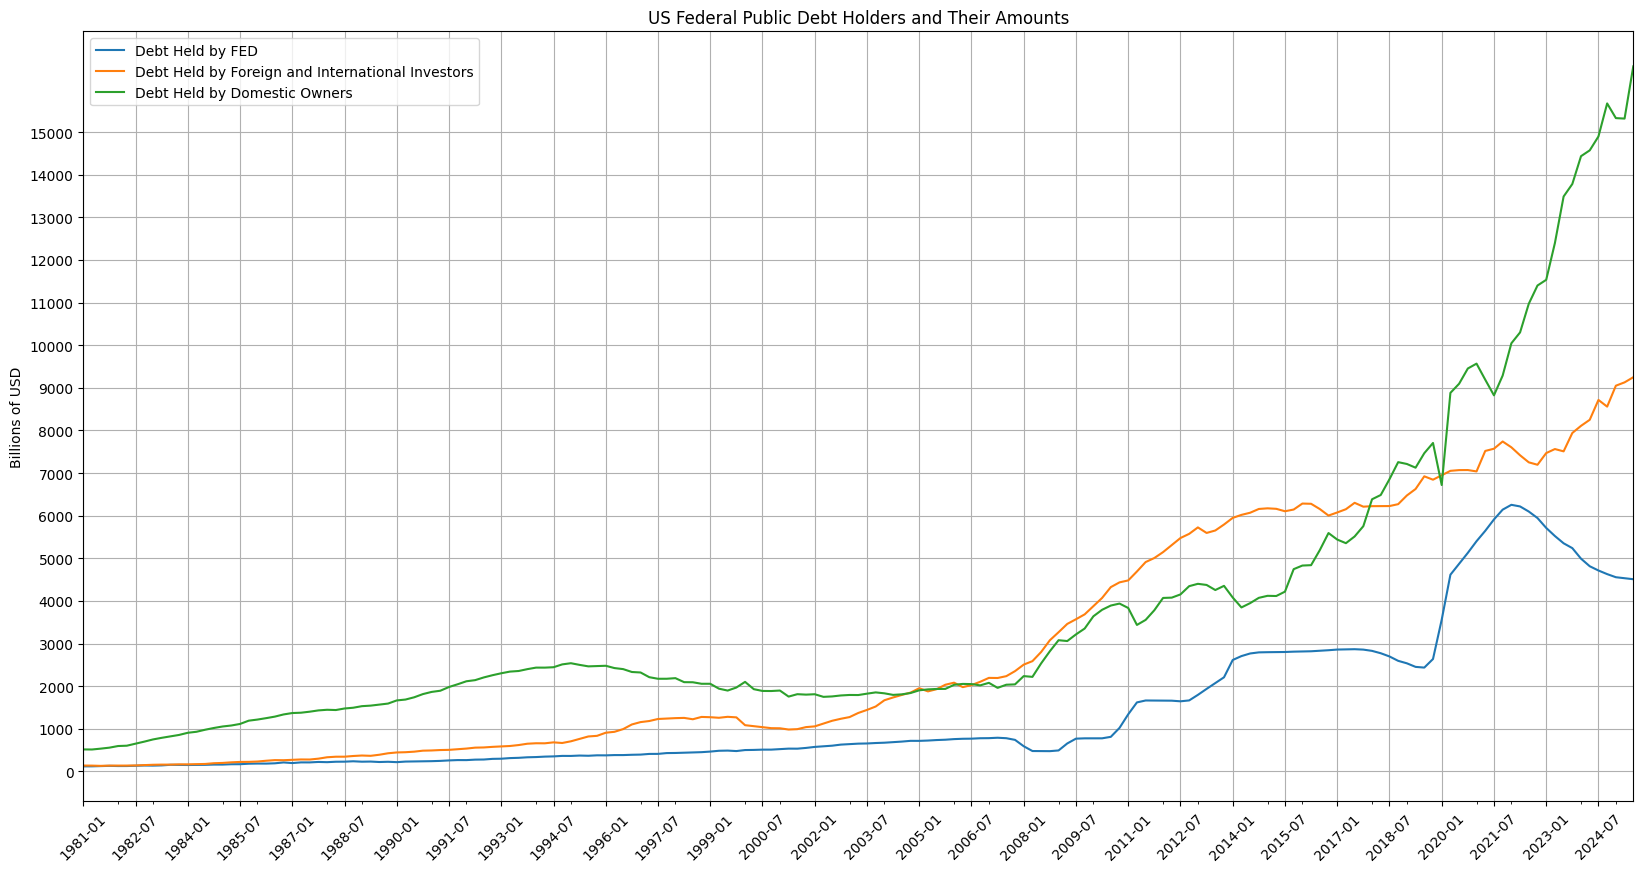

In [11]:
smaller_df = pub_debt_holders[[FEDERAL_DEBT_HELD_BY_FED, FEDERAL_DEBT_HELD_BY_FOREIGN, FEDERAL_DEBT_HELD_BY_DOMESTIC]]
ax = smaller_df.plot(figsize=(20,10), grid=True, title=FED_DEBT_HOLDERS_TITLE,
                     xticks=pub_debt_holders.index[::6], xlabel='', rot=45,
                     ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 16000e3, 1000e3))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "%.0f" % (x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pub_debt_holders.index[::6])))

#### Stacked Visualization Amounting to Total US Federal Debt

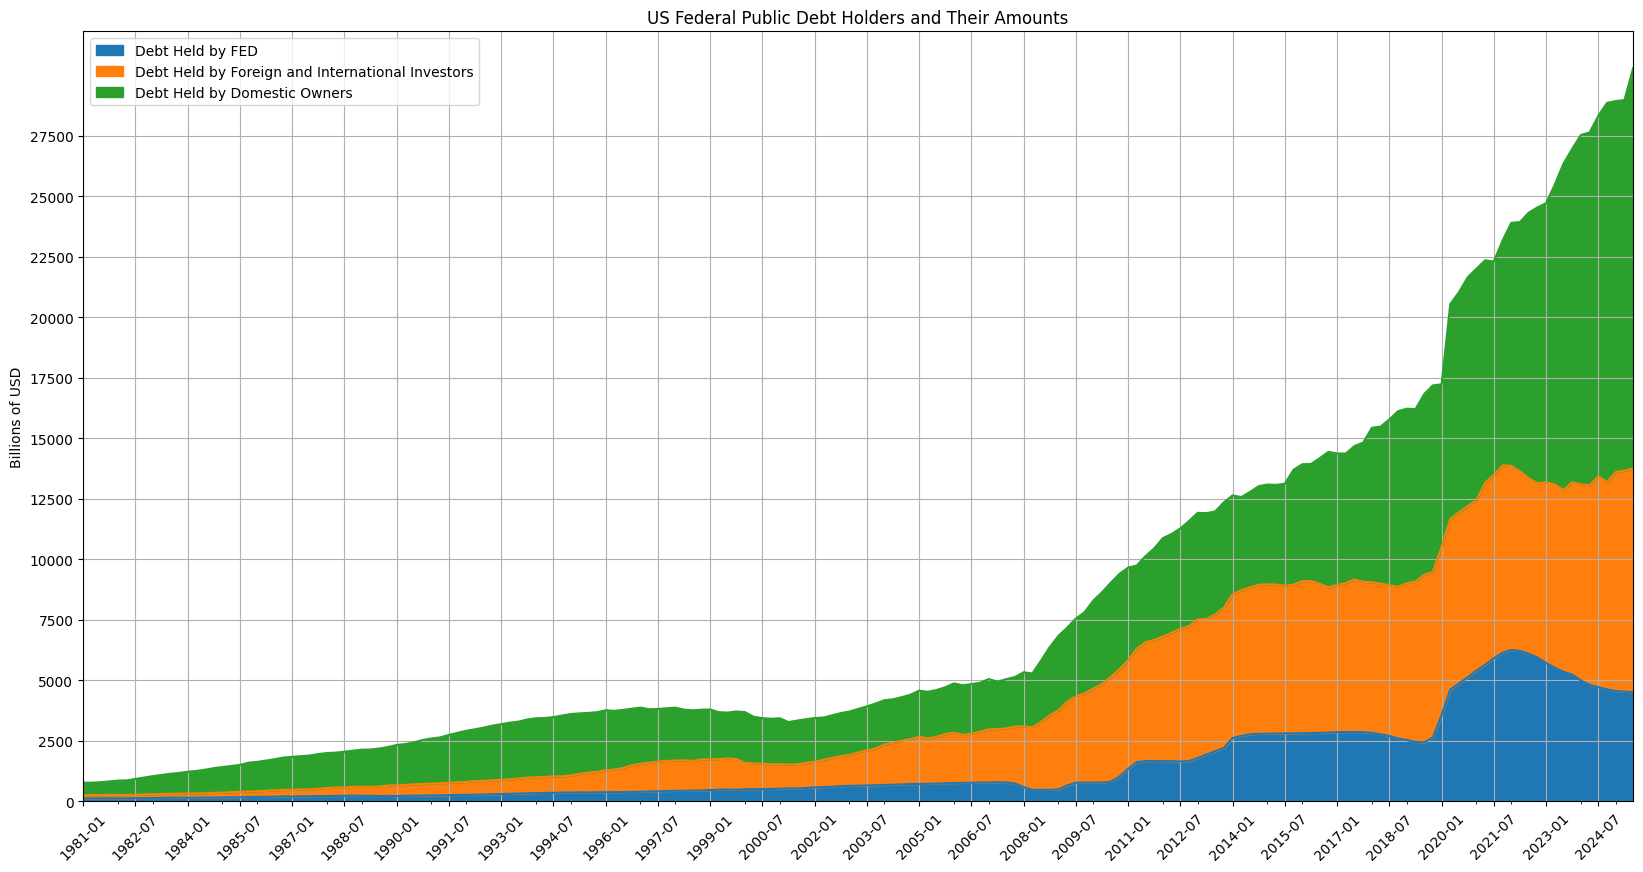

In [12]:
ax = smaller_df.plot.area(figsize=(20,10), grid=True, title=FED_DEBT_HOLDERS_TITLE,
                          xticks=pub_debt_holders.index[::6], xlabel='', rot=45,
                          ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 30000e3, 2500e3))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "%.0f" % (x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pub_debt_holders.index[::6])))

#### Visualization of Ownership as a Percentage of Total Federal Debt

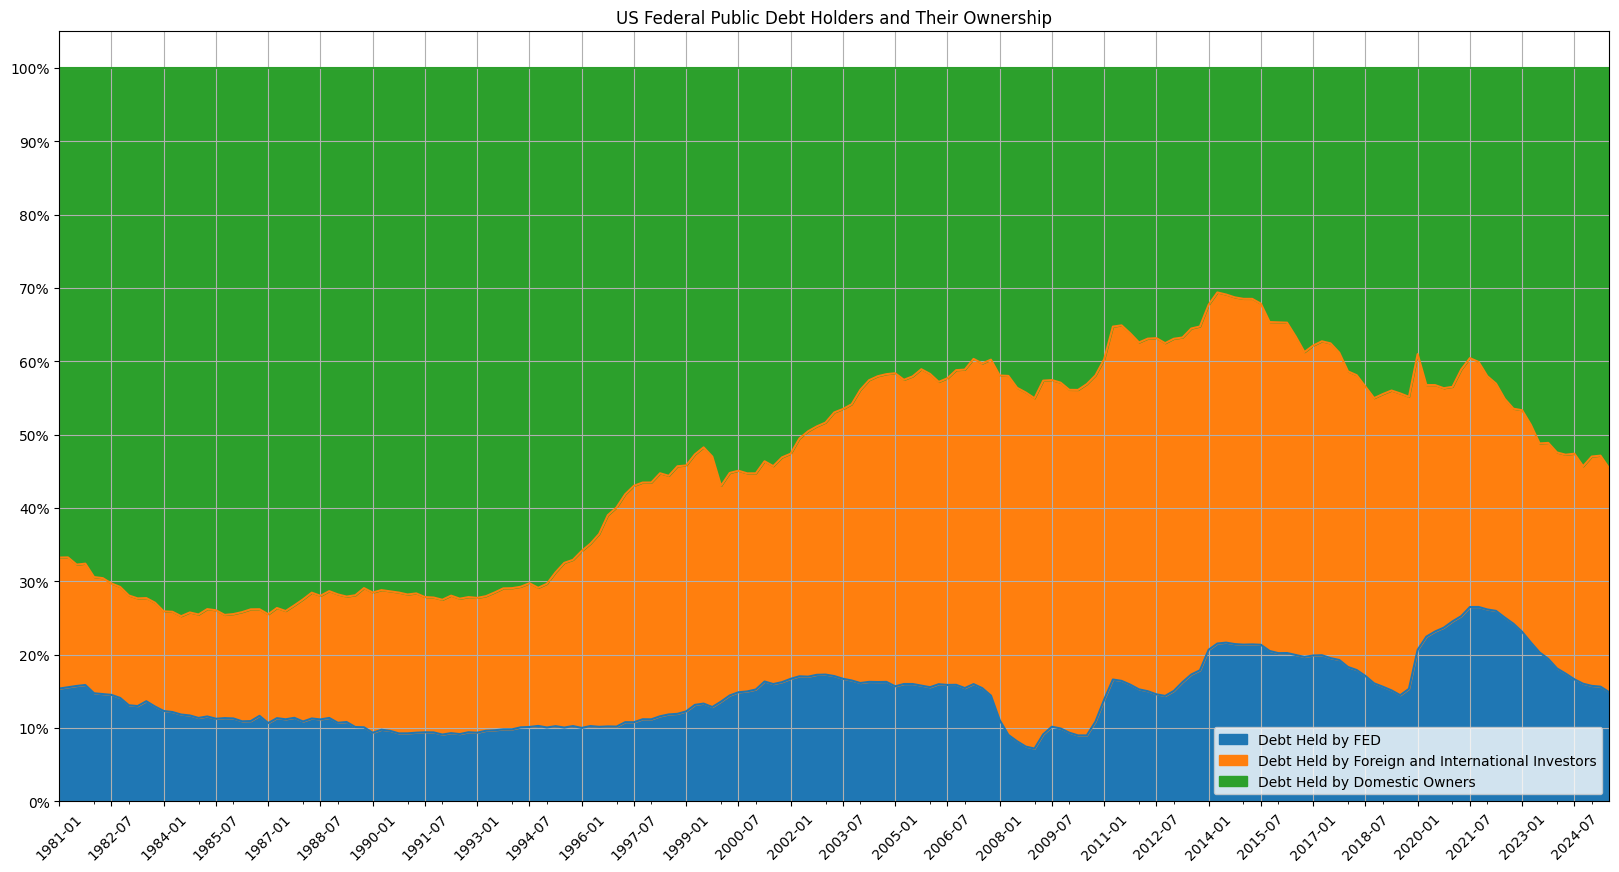

In [13]:
# Converting to percentages by dividing by total federal public debt.
# Dividing by a sum of FYGFDPUN and FDHBATN instead of by GFDEBTN because of a small issue in the Fred's dataset
smaller_df_pct = smaller_df.divide(pub_debt_holders.iloc[:, 1], axis=0)

ax = smaller_df_pct.plot.area(figsize=(20,10), grid=True, title=FED_DEBT_HOLDERS_PERCENTAGE_TITLE,
                              xticks=smaller_df_pct.index[::6], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, smaller_df_pct.index[::6])))

Let's look at ownership over the past 16 quarters.

In [14]:
PCNT_FORMAT = '{:.4%}'.format

# The last 4 years
smaller_df_pct.tail(16).style.format_index(IDX_FORMAT).format(PCNT_FORMAT).set_table_styles(
    [{'selector':'.index_name.level0', 'props': [('min-width', '78px')]}])

,Debt Held by FED,Debt Held by Foreign and International Investors,Debt Held by Domestic Owners
2021-10,26.5082%,33.4094%,40.0824%
2022-01,26.1678%,31.8124%,42.0198%
2022-04,25.9753%,30.9896%,43.0350%
2022-07,25.0700%,29.8168%,45.1132%
2022-10,24.2252%,29.3192%,46.4557%
2023-01,23.1167%,30.2191%,46.6642%
2023-04,21.6720%,29.6805%,48.6475%
2023-07,20.3130%,28.4981%,51.1890%
2023-10,19.4321%,29.4508%,51.1171%
2024-01,18.1280%,29.4475%,52.4245%


Percentage changes in the last quarter

In [15]:
df_change_last_quarter_1 = (smaller_df_pct.iloc[-1] - smaller_df_pct.iloc[-2])\
    .apply(PCNT_FORMAT).to_frame('Percentage change in ownership')

In [16]:
df_change_last_quarter_2 = (smaller_df.iloc[-1]-smaller_df.iloc[-2]).\
    apply('${:+,.0f}M'.format).to_frame('Changes over quarter starting on {:%Y-%m-%d}'.format(pub_debt_holders.index[-1]))

In [17]:
pd.concat([df_change_last_quarter_2, df_change_last_quarter_1], axis=1)

,Changes over quarter starting on 2025-07-01,Percentage change in ownership
Debt Held by FED,"$-23,143M",-0.7590%
Debt Held by Foreign and International Investors,"$+120,100M",-0.9782%
Debt Held by Domestic Owners,"$+1,225,148M",1.7372%


In [18]:
print('US Federal Public Debt changed by {:+.2f}B in quarter starting on {:%Y-%m-%d}'
      .format((pub_debt_holders.iloc[-1,1]-pub_debt_holders.iloc[-2,1])/1000., pub_debt_holders.index[-1].date()))

US Federal Public Debt changed by +1322.11B in quarter starting on 2025-07-01


### Changes in Federal Public Debt Ownership Over the Past Years
Let's see by how many percentage points each category of US Public Debt holders changed their ownership over the past 5 and 3 years.

In [19]:
periods = [3, 1]

In [20]:
df_pct_chg = pd.concat(
    [(smaller_df_pct - smaller_df_pct.shift(4*period)).iloc[-1] for period in periods], axis=1)
# Converting to billions of USD
df_chg = pd.concat([(smaller_df - smaller_df.shift(4*period)).iloc[-1] for period in periods], axis=1) / 1e3
df_pct_chg.columns = df_chg.columns = ['Over past {:d} years'.format(period) for period in periods]
df_pct_chg.index = df_chg.index = df_chg.index.map(lambda lbl: lbl[len(PFX):])

In [21]:
df_pct_chg.sort_values(by=df_pct_chg.columns[0], inplace=True)

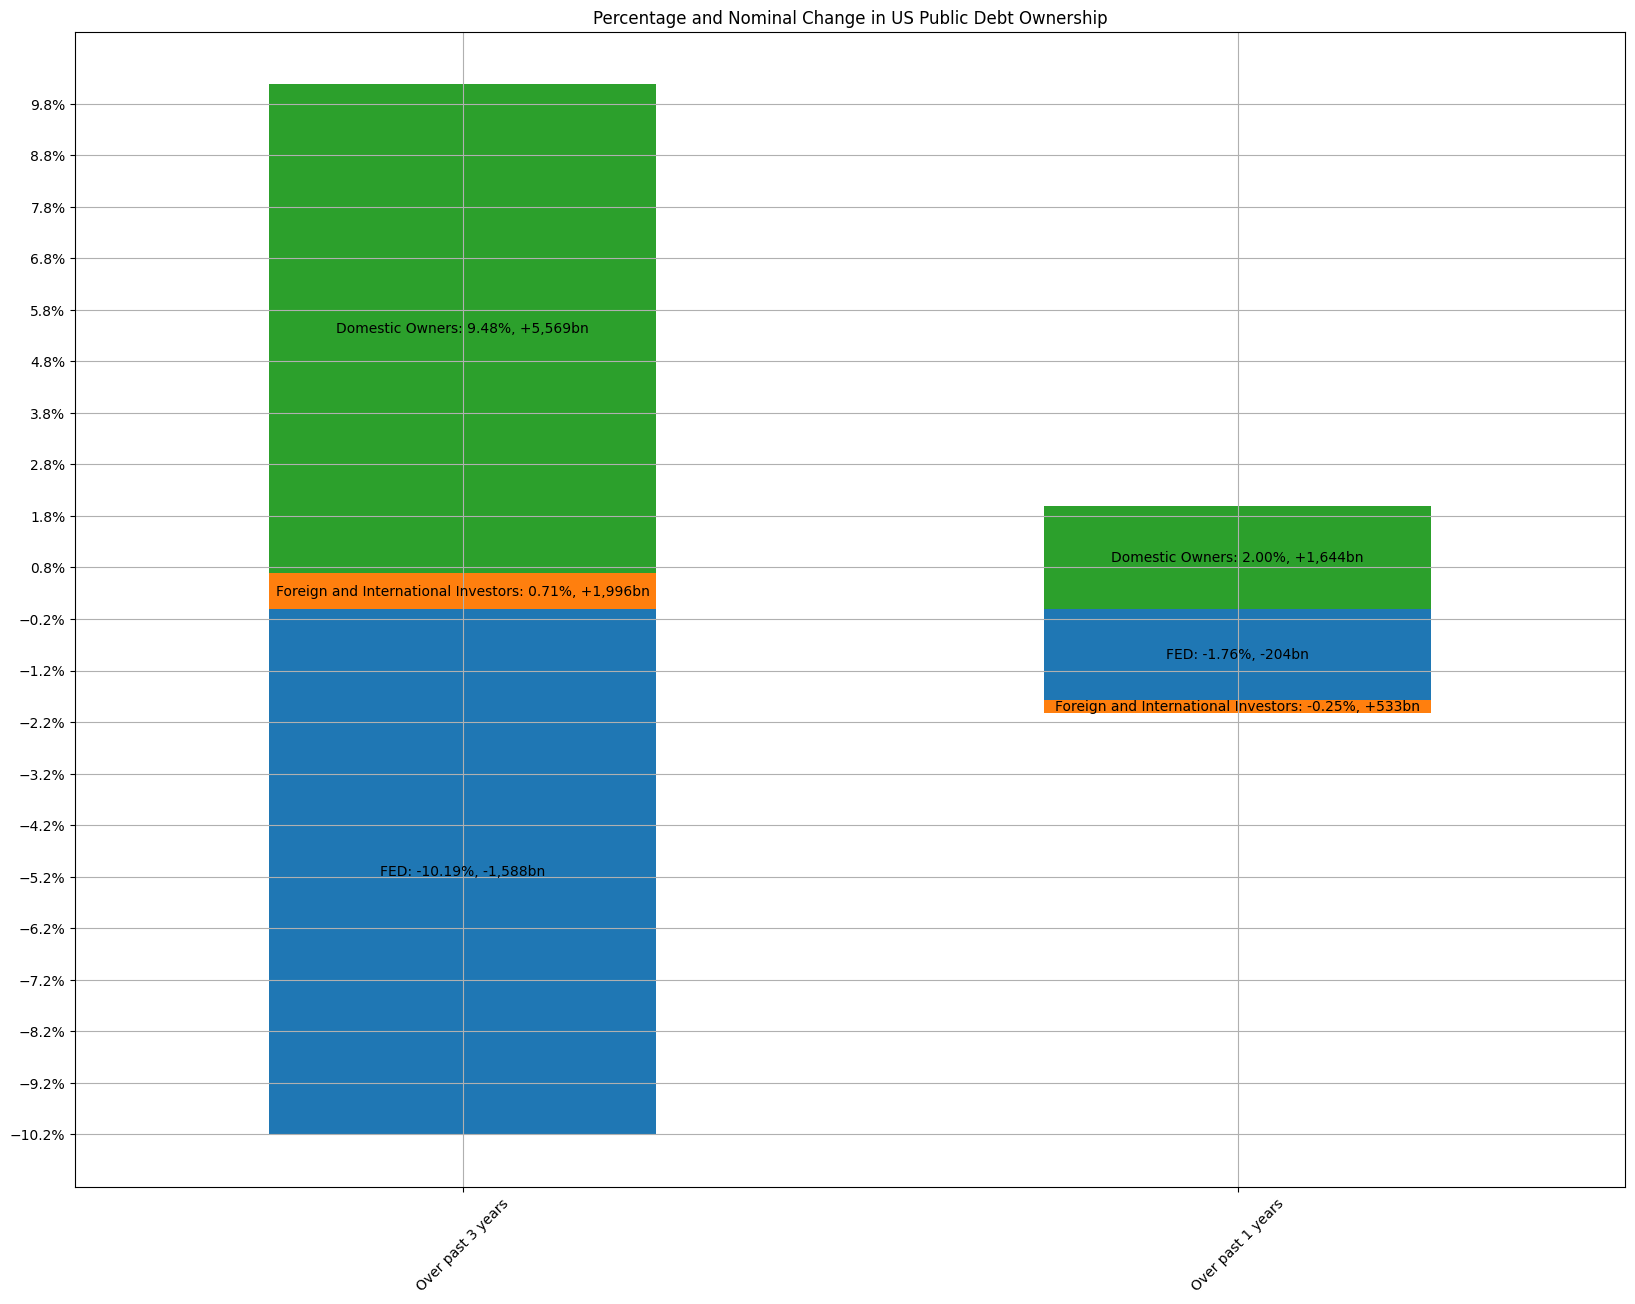

In [22]:
y_min = df_pct_chg.loc[df_pct_chg.iloc[:,0] < 0., df_pct_chg.columns[0]].sum().item()
y_max = df_pct_chg.loc[df_pct_chg.iloc[:,0] > 0., df_pct_chg.columns[0]].sum().item()
ax = df_pct_chg.T.plot.bar(figsize=(20,15), grid=True, title='Percentage and Nominal Change in US Public Debt Ownership',
                           stacked=True, rot=45, yticks=np.arange(y_min, y_max, .01))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.get_legend().remove()
for c in ax.containers:
    labels = [c.get_label() + f': {a:.2%}, {df_chg.loc[c.get_label()].iloc[i]:+,.0f}bn'
          if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type='center')
    #ax.bar_label(c, fmt=c.get_label() + ': {:.2%}', label_type='center')

### Zooming in on foreign and international holders
Unfortunately in this section I only operate with data starting from 2024, which is when I started collecting TIC data.

In [24]:
# Taking a subset consisting of total ownership by the public and ownership by the FED, Foregin official institutions,
# Other Foreign institutions, and domestic owners
pub_debt_holders_sub = pub_debt_holders.iloc[:,[1,3,5,6,7]].dropna()

#### Stacked Visualization Amounting to Total Public Debt

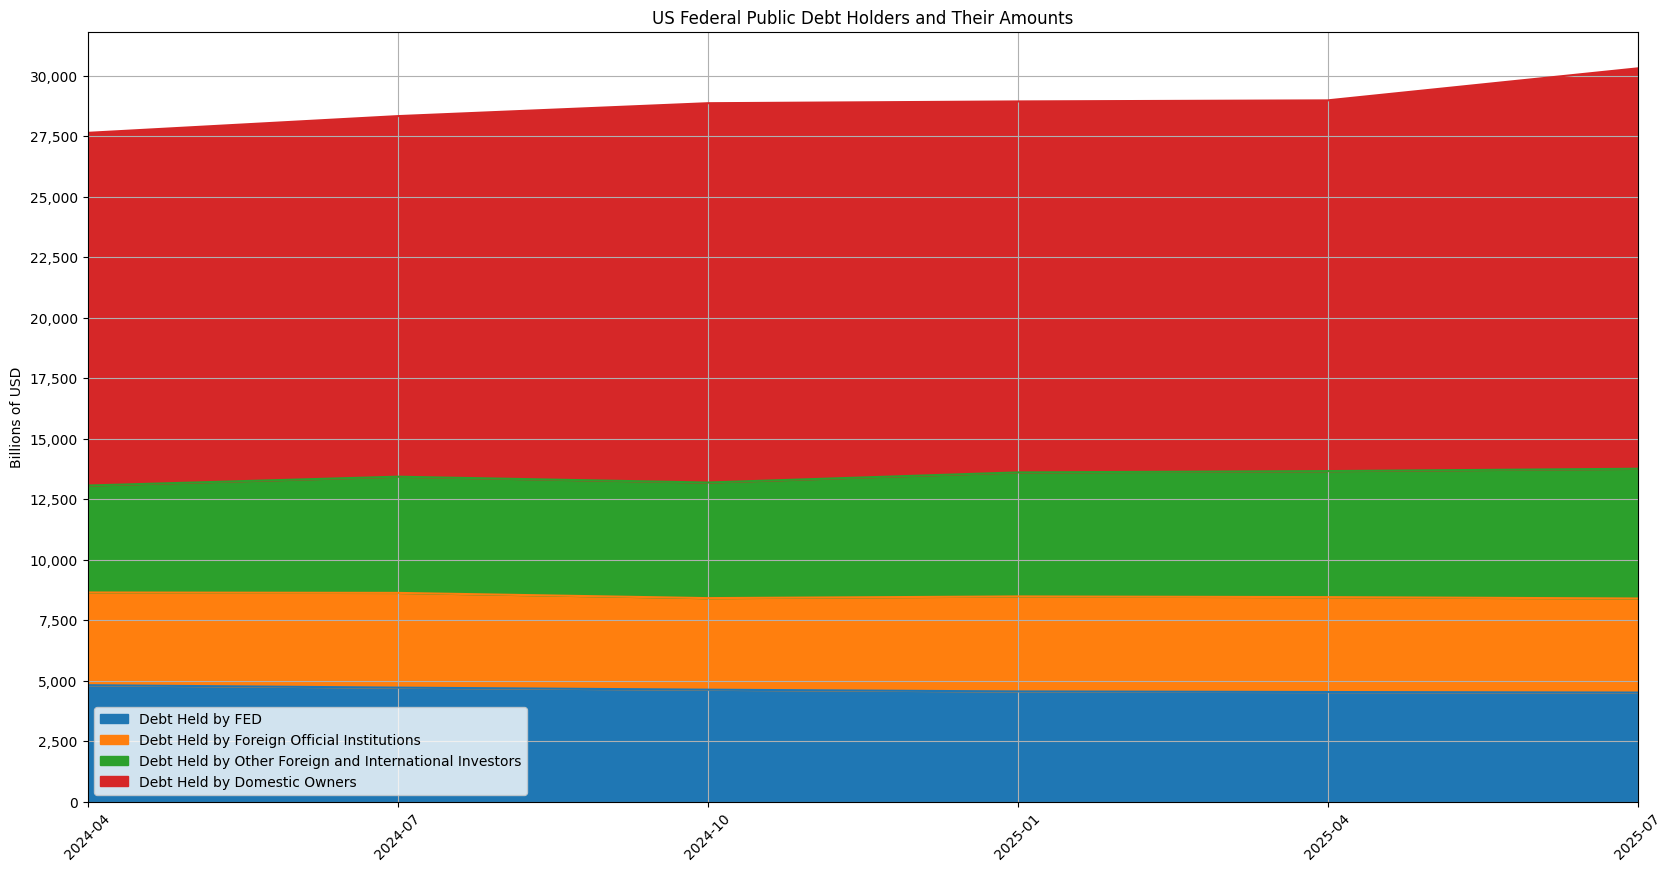

In [25]:
y_max = pub_debt_holders.loc[:, FEDERAL_DEBT_HELD_BY_PUBLIC].max()
y_step = 2500e3
y_max = (y_max + y_max % y_step if y_max % y_step else y_max) + 1
ax = pub_debt_holders_sub.iloc[:,1:].plot.area(figsize=(20,10), grid=True, title=FED_DEBT_HOLDERS_TITLE,
                                               xticks=pub_debt_holders_sub.index, xlabel='', rot=45,
                                               ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, y_max, y_step))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pub_debt_holders_sub.index)))

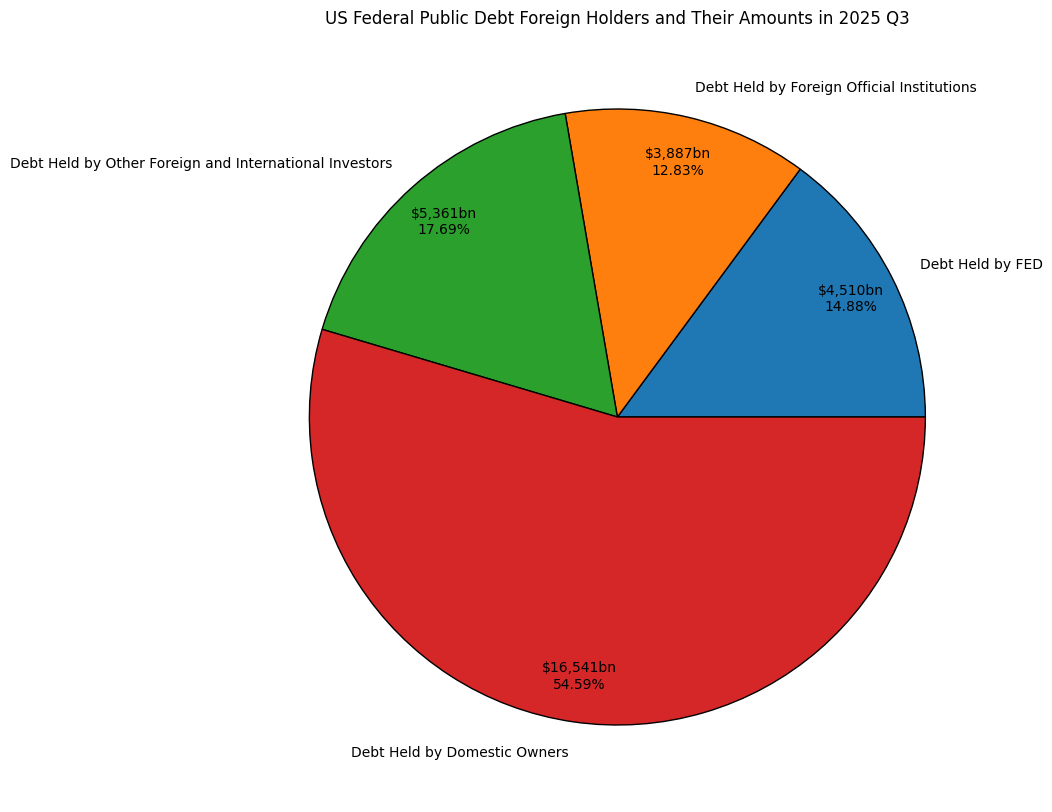

In [26]:
ax = pub_debt_holders_sub.iloc[-1,1:].plot.pie(
    figsize=(20,10), grid=True, ylabel='',
    autopct=lambda pct: f'${pct * pub_debt_holders_sub.iloc[-1,0] / 1e5:,.0f}bn\n{pct:.2f}%', pctdistance=0.85,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    title=FED_DEBT_FOREIGN_HOLDERS_TITLE + f' in {pub_debt_holders_sub.index[-1]:%Y} Q{pub_debt_holders_sub.index[-1].quarter}')

#### Visualization of Ownership as a Percentage of Total Federal Debt

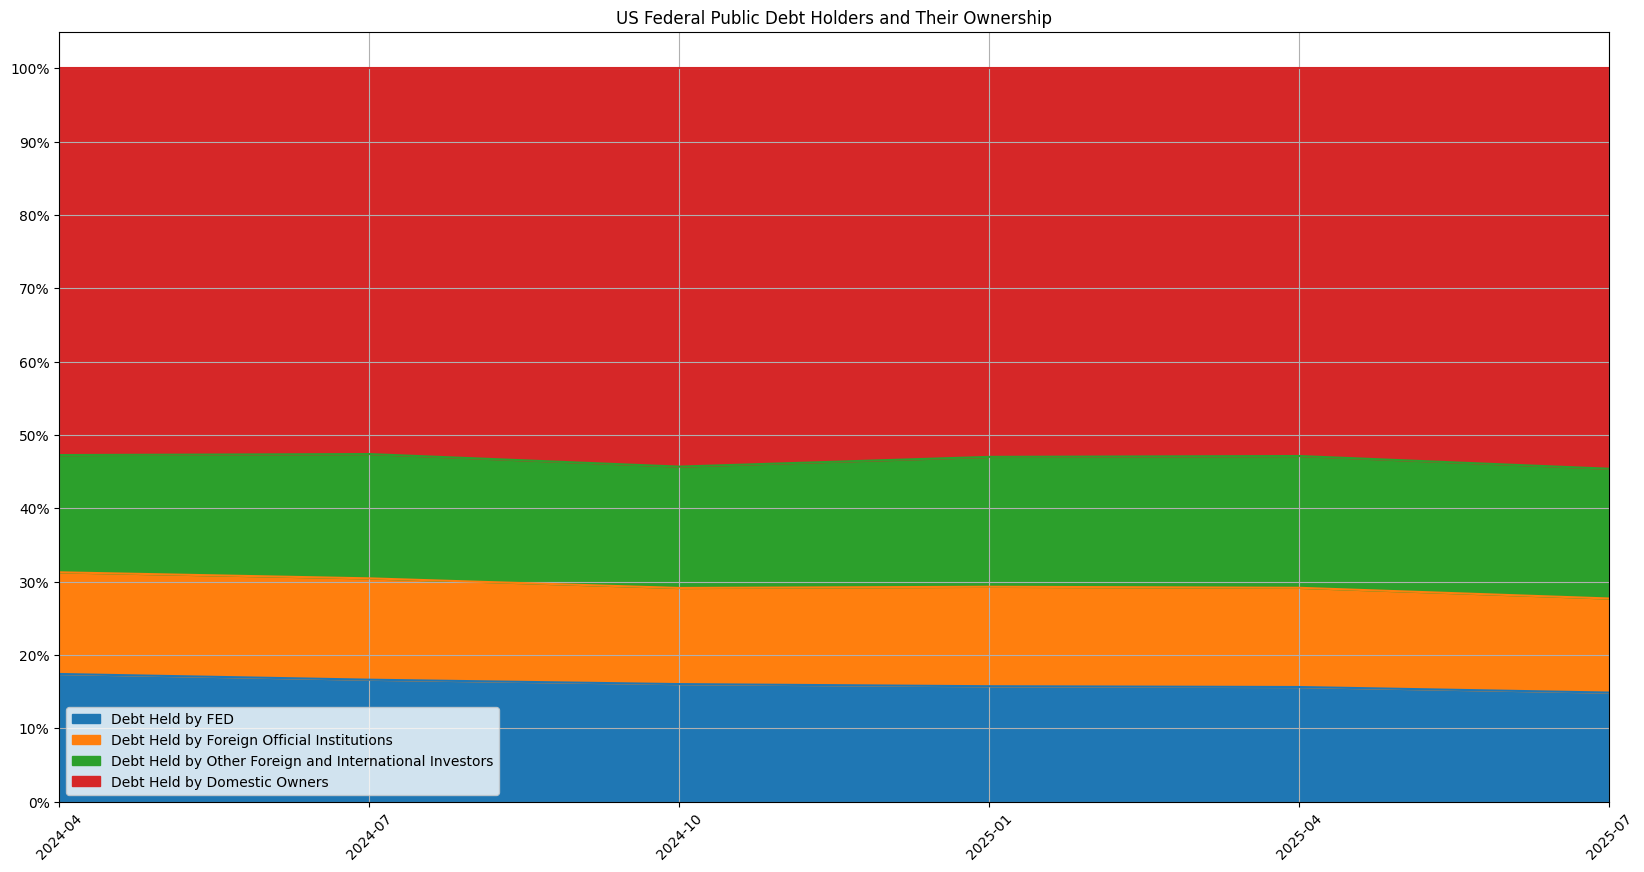

In [27]:
# Converting to percentages by dividing by total federal public debt.
# Dividing by a sum of FYGFDPUN and FDHBATN instead of by GFDEBTN because of a small issue in the Fred's dataset
smaller_df_pct = pub_debt_holders_sub.iloc[:,1:].divide(pub_debt_holders_sub.iloc[:, 0], axis=0)

ax = smaller_df_pct.plot.area(figsize=(20,10), grid=True, title=FED_DEBT_HOLDERS_PERCENTAGE_TITLE,
                              xticks=smaller_df_pct.index, xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, smaller_df_pct.index)))

#### Changes in Foreign Ownership YTD

In [28]:
num_quarters = pub_debt_holders_sub.index[-1].quarter
df = (pub_debt_holders_sub.iloc[-1:,1:]-pub_debt_holders_sub.iloc[int(-1 - num_quarters), 1:]).T / 1e3
df.columns = [f'Ownership changes over the past {num_quarters} quarters']
df.style.format('{:+,.2f}B').set_table_styles([{'selector':'.col0', 'props': [('min-width', '110px')]}])

,Ownership changes over the past 3 quarters
Debt Held by FED,-119.75B
Debt Held by Foreign Official Institutions,+104.10B
Debt Held by Other Foreign and International Investors,+585.30B
Debt Held by Domestic Owners,+869.50B


#### Foreign ownership by Country

In [29]:
tic_tbl5 = tic_tbl5.iloc[:, :-3]
tic_tbl5.style.format_index(IDX_FORMAT).format('{:,.0f}M').set_table_styles(
    [{'selector':'.index_name.level0', 'props': [('min-width', '78px')]},
     {'selector':'.col0', 'props': [('min-width', '110px')]}])

,Japan,United Kingdom,"China, Mainland",Cayman Islands,Belgium,Luxembourg,Canada,France,Ireland,Switzerland,Taiwan,Singapore,Hong Kong,India,Brazil,Norway,Saudi Arabia,"Korea, South",United Arab Emirates,Germany,Israel,All Other,Grand Total
2024-04,"1,126,100M","714,600M","770,700M","326,000M","312,400M","359,200M","341,600M","276,600M","330,000M","290,500M","259,300M","203,300M","226,600M","233,500M","223,600M","142,300M","135,400M","119,000M","69,900M","91,900M",nanM,"1,483,700M","8,036,200M"
2024-05,"1,106,000M","728,600M","768,300M","342,700M","313,000M","367,300M","356,300M","283,000M","336,800M","290,500M","265,400M","209,800M","224,200M","237,800M","223,200M","146,100M","136,300M","119,800M","70,800M","91,300M",nanM,"1,513,500M","8,130,700M"
2024-06,"1,091,400M","746,500M","780,200M","326,300M","318,000M","374,200M","372,500M","305,400M","336,100M","287,400M","267,900M","215,000M","226,600M","241,900M","227,000M","157,100M","140,200M","117,200M","70,100M","90,800M","69,700M","1,488,000M","8,249,500M"
2024-07,"1,093,500M","733,500M","776,500M","380,100M","315,900M","389,300M","375,300M","291,100M","341,200M","289,400M","277,300M","229,800M","238,600M","238,800M","229,100M","160,300M","142,700M","123,100M","68,900M","104,900M","71,200M","1,510,100M","8,380,600M"
2024-08,"1,106,000M","749,200M","774,600M","424,200M","325,000M","395,700M","362,900M","312,500M","350,900M","299,300M","287,100M","234,800M","243,700M","245,900M","233,300M","166,000M","142,800M","123,300M","79,200M","99,100M","73,500M","1,529,100M","8,558,100M"
2024-09,"1,095,500M","769,300M","772,000M","424,600M","366,600M","407,100M","367,900M","328,900M","356,200M","305,500M","291,100M","243,800M","243,700M","247,200M","234,600M","173,500M","143,900M","127,300M","71,900M","103,800M","79,000M","1,561,800M","8,715,200M"
2024-10,"1,101,600M","746,500M","760,100M","418,300M","349,600M","413,500M","363,700M","330,100M","336,700M","297,900M","287,900M","244,700M","261,800M","241,400M","228,800M","167,100M","139,200M","127,300M","68,300M","102,300M","89,400M","1,563,200M","8,639,400M"
2024-11,"1,087,100M","766,900M","768,600M","405,300M","361,300M","417,800M","372,400M","332,500M","343,100M","298,700M","286,000M","252,200M","265,800M","234,000M","229,000M","162,500M","135,600M","127,500M","73,100M","100,100M","87,500M","1,562,100M","8,669,100M"
2024-12,"1,061,500M","722,800M","759,000M","423,000M","374,600M","423,900M","378,800M","332,300M","339,400M","298,700M","292,300M","249,000M","255,000M","219,100M","201,600M","157,600M","137,500M","124,900M","77,100M","97,200M","82,100M","1,551,000M","8,558,400M"
2025-01,"1,079,300M","740,200M","760,800M","406,900M","377,700M","409,900M","350,800M","335,400M","329,700M","301,200M","298,600M","247,600M","256,000M","225,700M","199,400M","173,100M","126,900M","122,200M","92,600M","105,700M","88,400M","1,531,400M","8,559,500M"


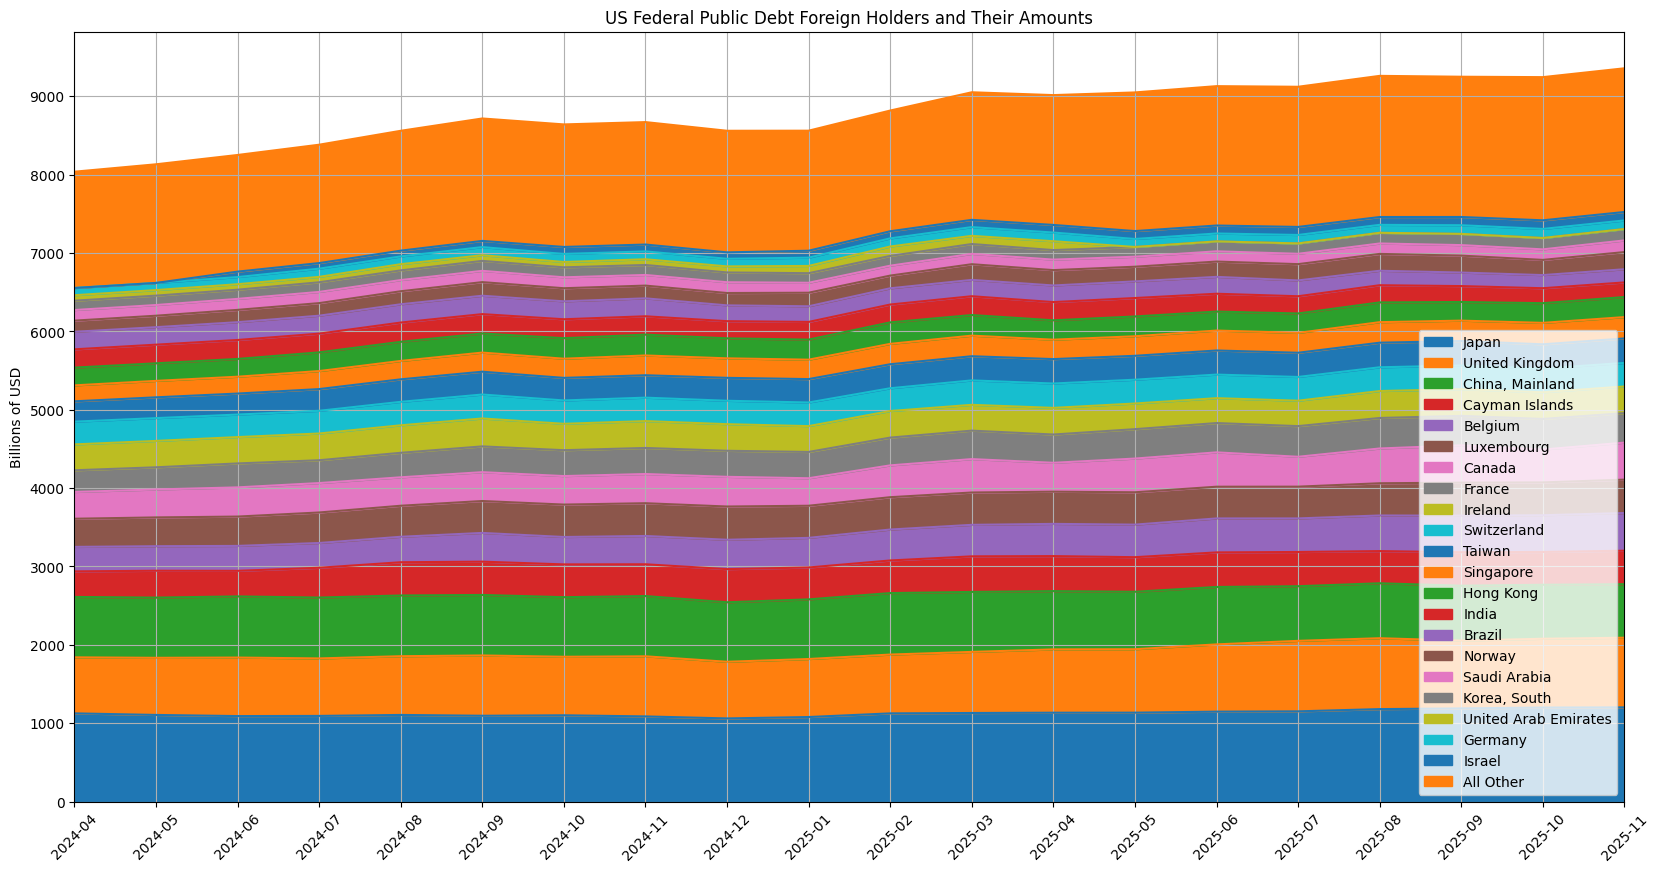

In [30]:
y_max = pub_debt_holders.loc[:, FEDERAL_DEBT_HELD_BY_FOREIGN].max()
y_step = 1000e3
y_max = (y_max + y_max % y_step if y_max % y_step else y_max) + 1
ax = tic_tbl5.iloc[:,:-1].plot.area(figsize=(20,10), grid=True, title=FED_DEBT_FOREIGN_HOLDERS_TITLE,
                                    xticks=tic_tbl5.index, xlabel='', rot=45,
                                    ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, y_max, y_step))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "%.0f" % (x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, tic_tbl5.index)))

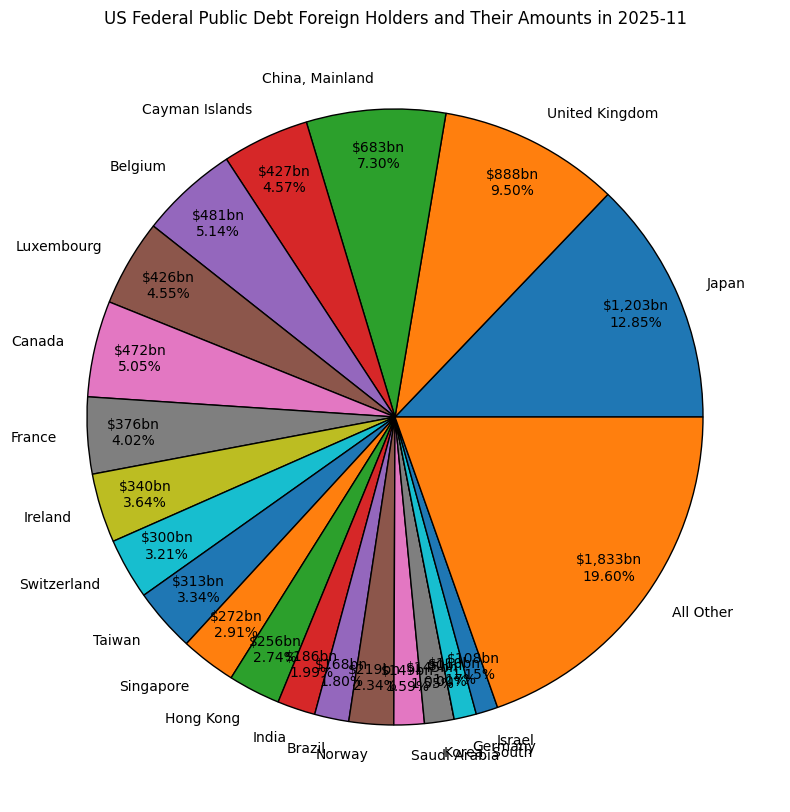

In [31]:
ax = tic_tbl5.iloc[-1,:-1].plot.pie(figsize=(20,10), grid=True, ylabel='',
                                    autopct=lambda pct: f'${pct * tic_tbl5.iloc[-1,-1] / 1e5:,.0f}bn\n{pct:.2f}%', pctdistance=0.85,
                                    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
                                    title=FED_DEBT_FOREIGN_HOLDERS_TITLE + f' in {tic_tbl5.index[-1]:%Y-%m}')

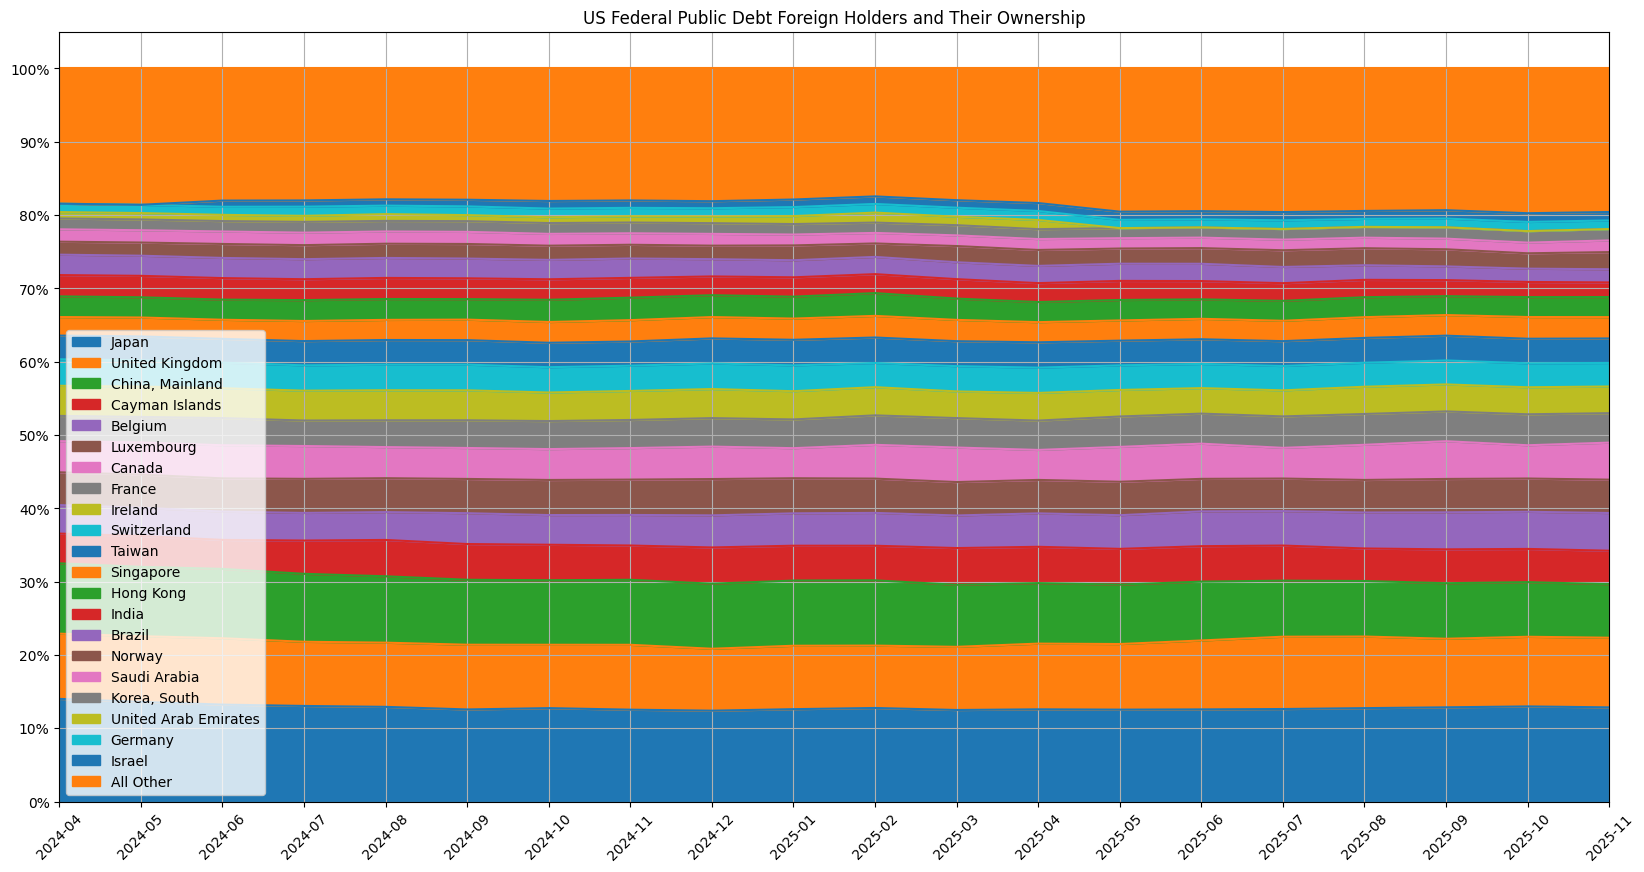

In [32]:
# Converting to percentages by dividing by total federal public debt.
# Dividing by a sum of FYGFDPUN and FDHBATN instead of by GFDEBTN because of a small issue in the Fred's dataset
smaller_df_pct = tic_tbl5.iloc[:,:-1].divide(tic_tbl5.iloc[:, -1], axis=0)

ax = smaller_df_pct.plot.area(figsize=(20,10), grid=True, title=FED_DEBT_FOREIGN_HOLDERS_PERCENTAGE_TITLE,
                              xticks=smaller_df_pct.index, xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, smaller_df_pct.index)))

#### Changes in Foreign Ownership YTD

In [33]:
num_months = tic_tbl5.index[-1].month
df = (tic_tbl5.iloc[-1:,:-1]-tic_tbl5.iloc[-1 - num_months,:-1]).T.sort_values(tic_tbl5.index[-1]).T
df.style.hide(axis='index').format('{:+,.0f}M').set_table_styles([{'selector':'.col0', 'props': [('min-width', '110px')]}])

"China, Mainland",Brazil,India,Ireland,Hong Kong,Switzerland,Luxembourg,Cayman Islands,Saudi Arabia,Germany,Taiwan,"Korea, South",Singapore,Israel,France,Norway,Canada,Belgium,Japan,United Kingdom,All Other,United Arab Emirates
"-76,400M","-33,500M","-32,600M",+900M,"+1,000M","+1,600M","+1,700M","+4,400M","+11,300M","+12,600M","+20,200M","+20,200M","+23,200M","+25,600M","+43,800M","+61,300M","+93,400M","+106,400M","+141,100M","+165,700M","+282,200M",+nanM


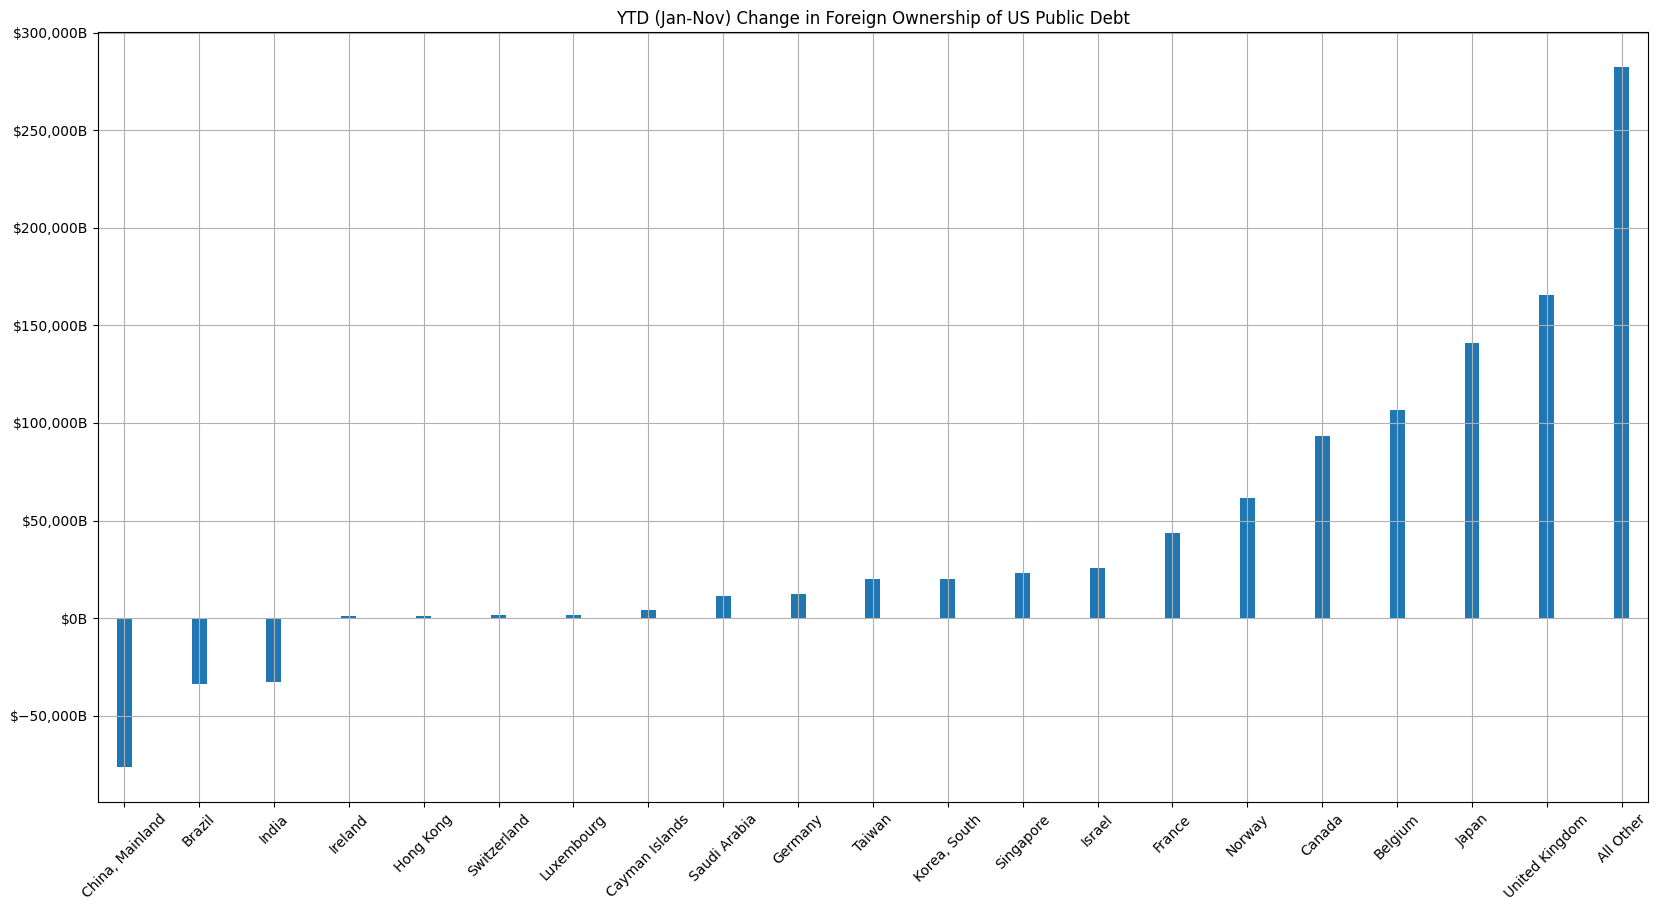

In [50]:
ax = df.iloc[-1].dropna().plot.bar(figsize=(20,10), grid=True, rot=45, width=0.2,
                          title=f'YTD ({tic_tbl5.index[-num_months]:%b}-{tic_tbl5.index[-1]:%b}) Change in Foreign Ownership of US Public Debt')
# Please uncomment if you want full names rather than ticker names
# ax.set_xticklabels([ticker_to_name[ticker] for ticker in cap_chg.iloc[-cut_off:].index], rotation=45, ha='right')
ax.yaxis.set_major_formatter('${x:,.0f}B')